In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# ================== CONFIGURAÇÃO ==================
IMAGE_SIZE = (128, 128)  # Tamanho das imagens
BATCH_SIZE = 32
NUM_CLASSES = 5  # Altere para número de suas classes
EPOCHS = 30

#preparo de dados

def load_images_from_folder(folder_path):
    images = []
    labels = []

    #verificar se pasta existe
    if not os.path.exists(folder_path):
        print(f"ERRO: Pasta '{folder_path}' não encontrada!")
        print("Crie a pasta com esta estrutura:")
        print("pasta de teste/")
        print("├── classe1/")
        print("│   ├── img1.jpg")
        print("│   └── img2.jpg")
        print("├── classe2/")
        print("│   ├── img1.jpg")
        print("│   └── img2.jpg")
        print("└── classe3/")
        return np.array([]), np.array([]), []
    
    class_names = sorted([d for d in os.listdir(folder_path) 
                         if os.path.isdir(os.path.join(folder_path, d))])
    
    if not class_names:
        print(f"ERRO: Nenhuma subpasta encontrada em '{folder_path}'")
        return np.array([]), np.array([]), []
    
    print(f"Encontradas {len(class_names)} classes: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        image_count = 0
        
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(class_path, image_file)
                try:
                    img = Image.open(image_path).convert('RGB')
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0  # Normalizar [0, 1]
                    images.append(img_array)
                    labels.append(class_idx)
                    image_count += 1
                except Exception as e:
                    print(f"Erro ao carregar {image_path}: {e}")
        
        print(f"Classe '{class_name}': {image_count} imagens")
    
    return np.array(images), np.array(labels), class_names

In [3]:
# ================== DIAGNÓSTICO DOS DADOS ==================
def diagnosticar_dados(X, y, class_names):
    print("\n" + "="*50)
    print("DIAGNÓSTICO COMPLETO DOS DADOS")
    print("="*50)
    
    if len(X) == 0:
        print("❌ NENHUMA IMAGEM CARREGADA!")
        return False
    
    print(f"✅ Total de imagens: {len(X)}")
    print(f"✅ Número de classes: {len(class_names)}")
    print(f"✅ Formato das imagens: {X[0].shape}")
    
    # Distribuição de classes
    print("\n📊 DISTRIBUIÇÃO DAS CLASSES:")
    for i, class_name in enumerate(class_names):
        count = np.sum(y == i)
        porcentagem = count / len(y) * 100
        print(f"   {class_name}: {count} imagens ({porcentagem:.1f}%)")
    
    # Verificar balanceamento
    counts = [np.sum(y == i) for i in range(len(class_names))]
    min_count = min(counts)
    max_count = max(counts)
    
    if min_count == 0:
        print("❌ ALERTA: Alguma classe não tem nenhuma imagem!")
        return False
    
    if max_count / min_count > 3:
        print("⚠️  ALERTA: Classes desbalanceadas (mais de 3x diferença)")
    else:
        print("✅ Classes relativamente balanceadas")
    
    # Verificar normalização
    print(f"\n🔍 VALORES DOS PIXELS:")
    print(f"   Mínimo: {X.min():.3f} (deve ser próximo de 0)")
    print(f"   Máximo: {X.max():.3f} (deve ser próximo de 1)")
    print(f"   Média: {X.mean():.3f}")
    
    if X.min() < 0 or X.max() > 1:
        print("❌ ERRO: Imagens não estão normalizadas entre 0 e 1!")
        return False
    else:
        print("✅ Imagens corretamente normalizadas")
    
    # Mostrar exemplo de imagens
    print(f"\n👀 EXEMPLO DE IMAGENS (primeiras 3):")
    plt.figure(figsize=(12, 4))
    for i in range(min(3, len(X))):
        plt.subplot(1, 3, i+1)
        plt.imshow(X[i])
        plt.title(f'Classe: {class_names[y[i]]}\nShape: {X[i].shape}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return True

In [4]:
# ================== PLOTAR GRÁFICOS ==================
def plot_training_history(history, hidden_units):
    plt.figure(figsize=(15, 5))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title(f'Training and Validation Accuracy\n({hidden_units} units)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'Training and Validation Loss\n({hidden_units} units)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [5]:
def create_img_cnn(input_shape, num_class, hidden_units=128):
    model = Sequential([
        # Bloco 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloco 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloco 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_class, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Carregando imagens...
Encontradas 8 classes: ['borda_4,22', 'borda_4,88', 'borda_5,63', 'borda_6,65', 'centro_4,22', 'centro_4,88', 'centro_5,63', 'centro_6,65']
Classe 'borda_4,22': 800 imagens
Classe 'borda_4,88': 800 imagens
Classe 'borda_5,63': 800 imagens
Classe 'borda_6,65': 810 imagens
Classe 'centro_4,22': 800 imagens
Classe 'centro_4,88': 810 imagens
Classe 'centro_5,63': 800 imagens
Classe 'centro_6,65': 800 imagens

DIAGNÓSTICO COMPLETO DOS DADOS
✅ Total de imagens: 6420
✅ Número de classes: 8
✅ Formato das imagens: (128, 128, 3)

📊 DISTRIBUIÇÃO DAS CLASSES:
   borda_4,22: 800 imagens (12.5%)
   borda_4,88: 800 imagens (12.5%)
   borda_5,63: 800 imagens (12.5%)
   borda_6,65: 810 imagens (12.6%)
   centro_4,22: 800 imagens (12.5%)
   centro_4,88: 810 imagens (12.6%)
   centro_5,63: 800 imagens (12.5%)
   centro_6,65: 800 imagens (12.5%)
✅ Classes relativamente balanceadas

🔍 VALORES DOS PIXELS:
   Mínimo: 0.000 (deve ser próximo de 0)
   Máximo: 1.000 (deve ser próximo de 1)

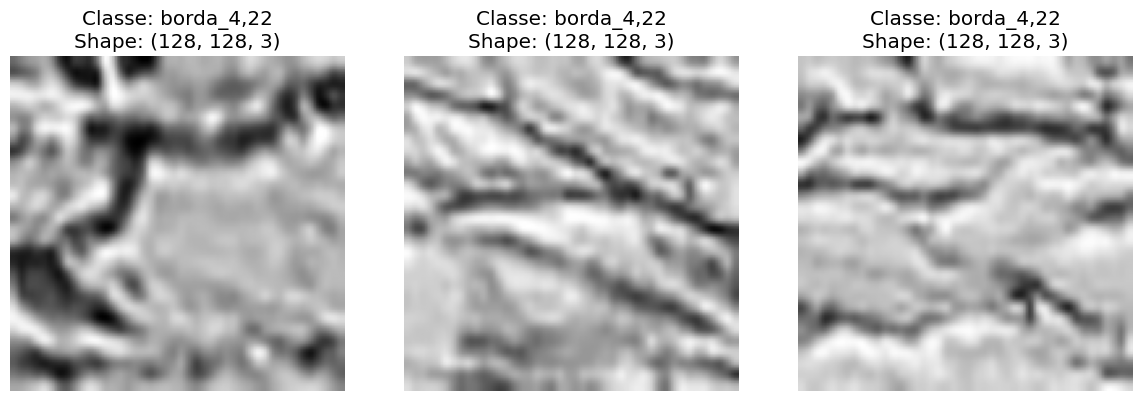


Carregadas 6420 imagens de 8 classes
📈 Dados divididos:
   Treino: 5136 imagens
   Teste: 1284 imagens

🧪 Testando com 32 unidades ocultas...


c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 Summary do modelo (32 unidades):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,234,472 (65.74 MB)

 Trainable params: 17,232,232 (65.74 MB)

 Non-trainable params: 2,240 (8.75 KB)

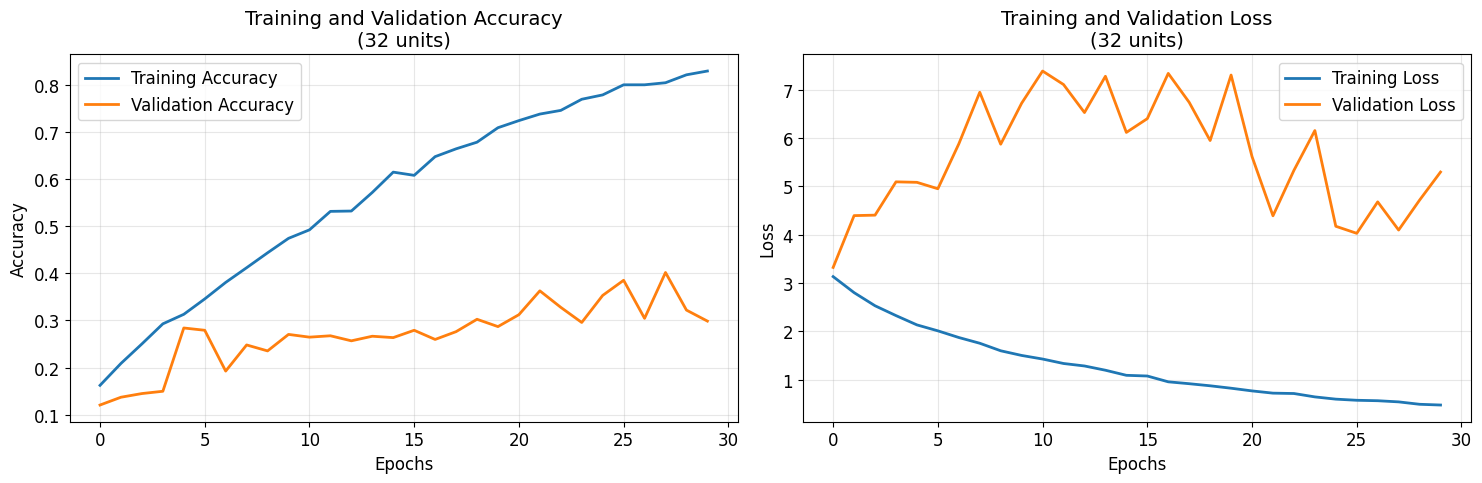

📊 Resultados para 32 unidades:
   Melhor acurácia treino: 0.8291
   Melhor acurácia validação: 0.4018

🧪 Testando com 64 unidades ocultas...

📋 Summary do modelo (64 unidades):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,234,472 (65.74 MB)

 Trainable params: 17,232,232 (65.74 MB)

 Non-trainable params: 2,240 (8.75 KB)

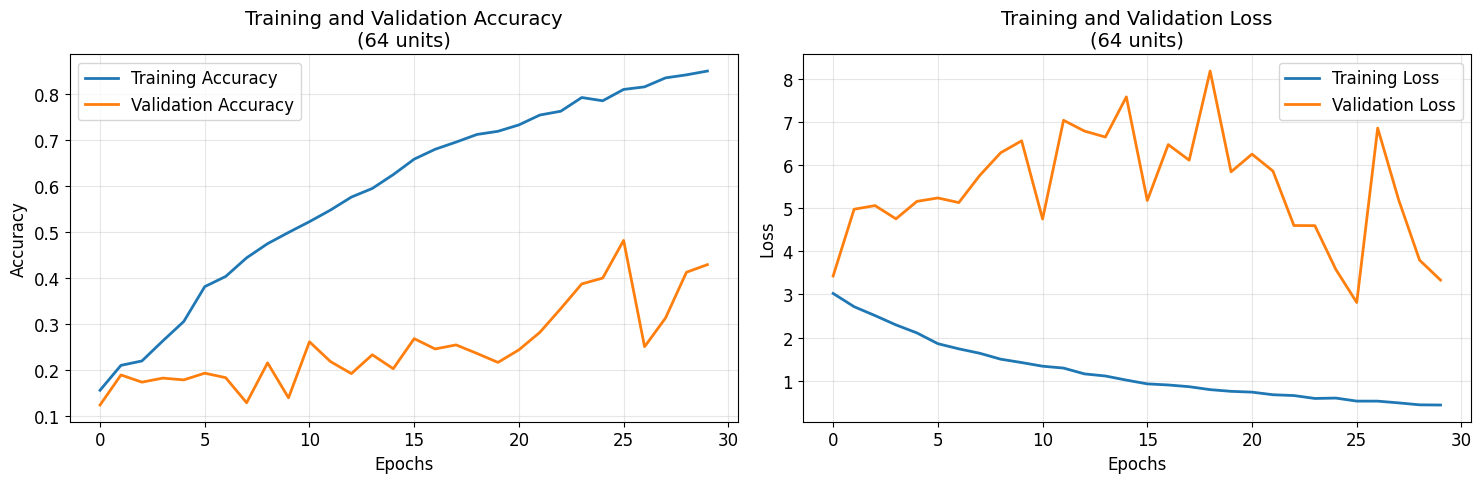

📊 Resultados para 64 unidades:
   Melhor acurácia treino: 0.8488
   Melhor acurácia validação: 0.4815

🧪 Testando com 128 unidades ocultas...

📋 Summary do modelo (128 unidades):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,234,472 (65.74 MB)

 Trainable params: 17,232,232 (65.74 MB)

 Non-trainable params: 2,240 (8.75 KB)

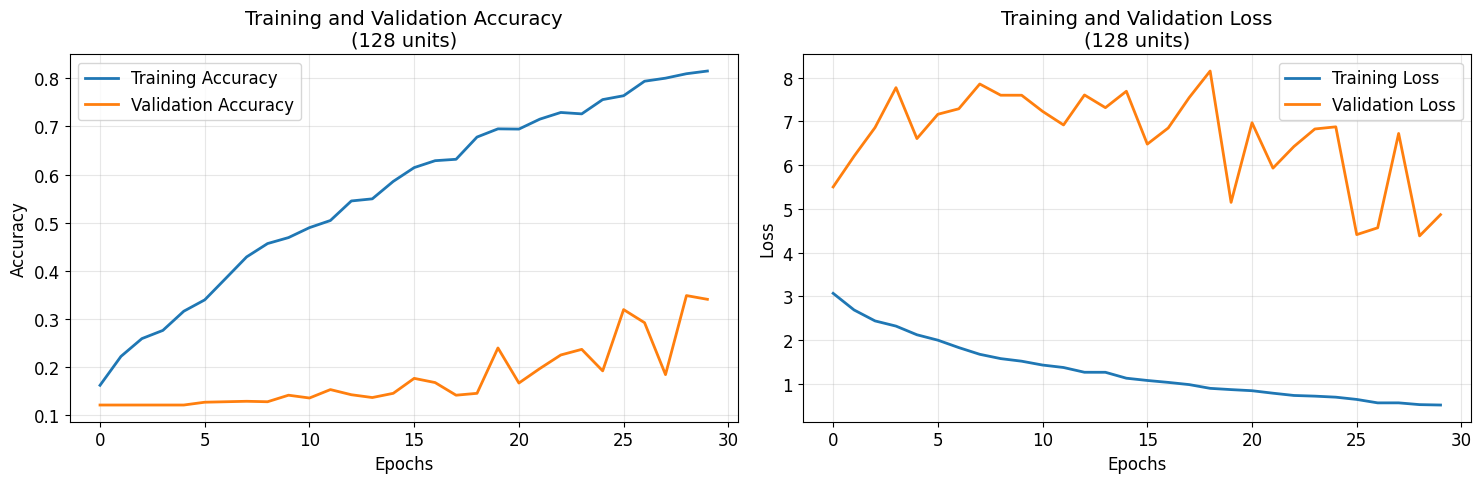

📊 Resultados para 128 unidades:
   Melhor acurácia treino: 0.8152
   Melhor acurácia validação: 0.3482

🧪 Testando com 256 unidades ocultas...

📋 Summary do modelo (256 unidades):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,234,472 (65.74 MB)

 Trainable params: 17,232,232 (65.74 MB)

 Non-trainable params: 2,240 (8.75 KB)

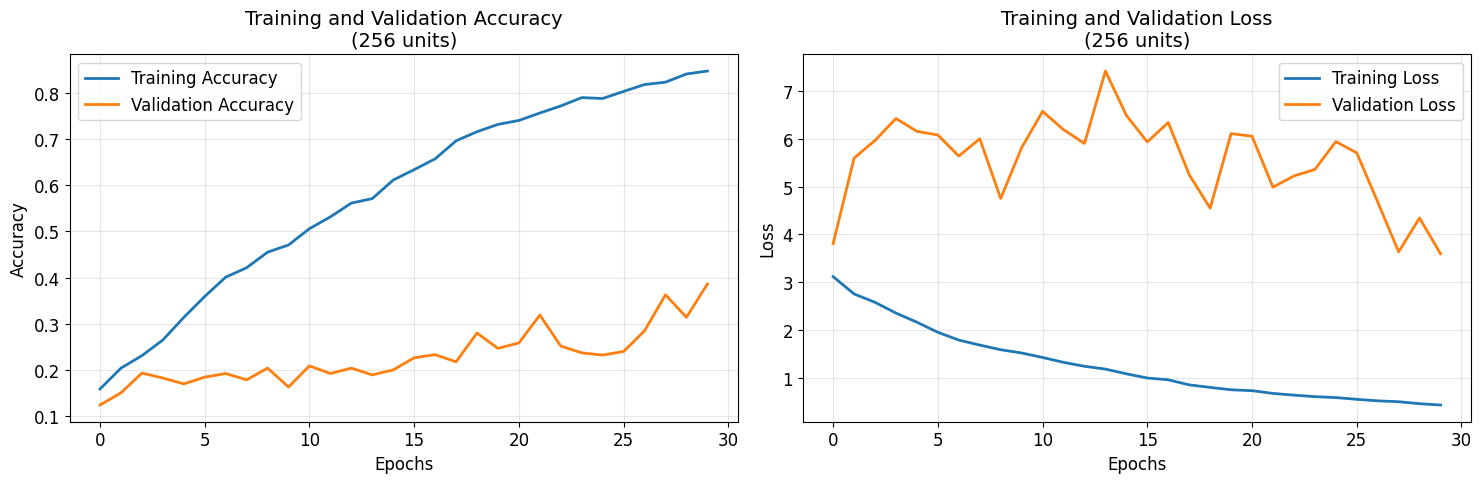

📊 Resultados para 256 unidades:
   Melhor acurácia treino: 0.8466
   Melhor acurácia validação: 0.3862

📈 COMPARAÇÃO FINAL DAS ARQUITETURAS:
   32 unidades: 0.4018 acurácia
   64 unidades: 0.4815 acurácia
   128 unidades: 0.3482 acurácia
   256 unidades: 0.3862 acurácia

🏆 MELHOR ARQUITETURA: 64 unidades ocultas
🎯 Melhor acurácia de validação: 0.4815

🎓 Treinando modelo final...
Epoch 1/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1675 - loss: 3.0253 - val_accuracy: 0.1206 - val_loss: 4.0732
Epoch 2/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2128 - loss: 2.7261 - val_accuracy: 0.1206 - val_loss: 4.6455
Epoch 3/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.2369 - loss: 2.5240 - val_accuracy: 0.1498 - val_loss: 4.7287
Epoch 4/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.2600 - loss: 2.4006 - val_accuracy: 0.1946 - val_loss: 4.8587
Epoch 5/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3040 - loss: 2.1406 - val_accuracy:

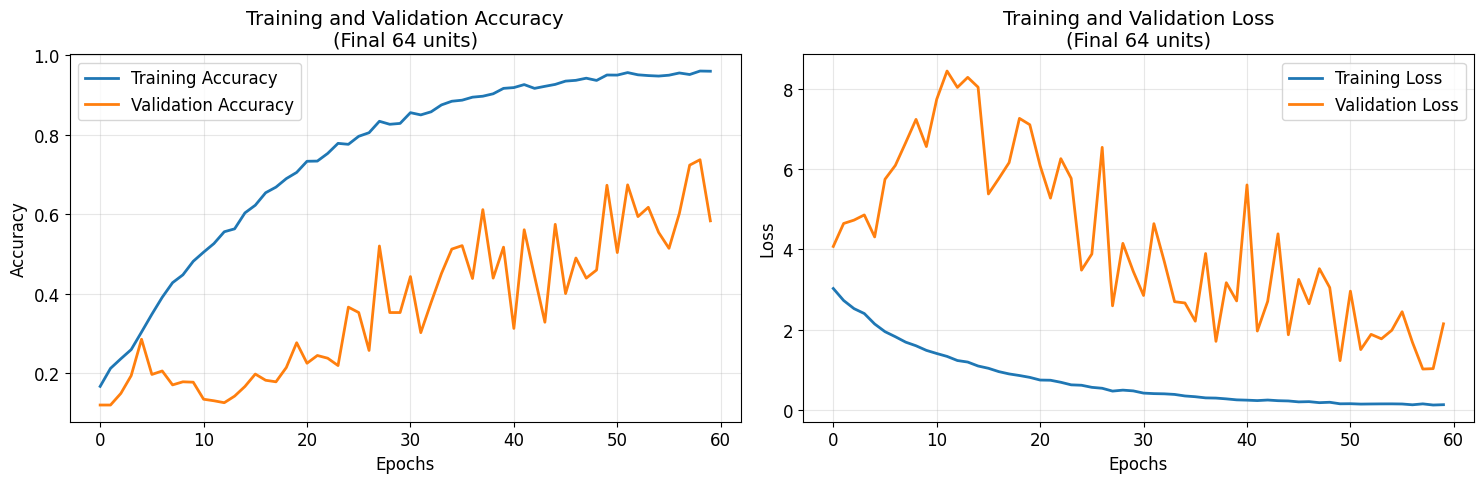


✅ ACURÁCIA FINAL NO TESTE: 0.5280
⚠️  Resultado regular: Acurácia entre 50-70%

📋 SUMMARY DO MODELO FINAL:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,698,938 (197.22 MB)

 Trainable params: 17,232,232 (65.74 MB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 34,464,466 (131.47 MB)

In [6]:
# ================== USO PRÁTICO ==================
def main():
    # 1. Carregar imagens da pasta
    dataset_folder = "pasta de teste"
    
    print("Carregando imagens...")
    X, y, class_names = load_images_from_folder(dataset_folder)
    
    # Executar diagnóstico
    if not diagnosticar_dados(X, y, class_names):
        print("❌ Problemas encontrados nos dados. Corrija antes de continuar.")
        return
    
    print(f"\nCarregadas {len(X)} imagens de {len(class_names)} classes")

    # 2. Dividir dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"📈 Dados divididos:")
    print(f"   Treino: {len(X_train)} imagens")
    print(f"   Teste: {len(X_test)} imagens")


    # Criar data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Ajustar o data augmentation aos dados de treino
    datagen.fit(X_train)
    
    # Callbacks para melhor treinamento
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]
    
    # 3. Encontrar melhor arquitetura
    best_accuracy = 0
    best_units = 0
    all_val_accuracies = []
    all_units = [32, 64, 128, 256]
    
    for hidden_units in all_units:
        print(f"\n" + "="*50)
        print(f"🧪 Testando com {hidden_units} unidades ocultas...")
        
        model = create_img_cnn(X_train[0].shape, len(class_names), hidden_units)
        
        # Mostrar summary do modelo
        print(f"\n📋 Summary do modelo ({hidden_units} unidades):")
        model.summary()
        
        # Treinar
        history = model.fit(X_train, y_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          verbose=0)
        
        # Plotar gráfico
        plot_training_history(history, hidden_units)
        
        # Avaliar
        val_accuracy = max(history.history['val_accuracy'])
        train_accuracy = max(history.history['accuracy'])
        all_val_accuracies.append(val_accuracy)
        
        print(f"📊 Resultados para {hidden_units} unidades:")
        print(f"   Melhor acurácia treino: {train_accuracy:.4f}")
        print(f"   Melhor acurácia validação: {val_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_units = hidden_units
            
    # Plotar comparação entre arquiteturas
    print(f"\n📈 COMPARAÇÃO FINAL DAS ARQUITETURAS:")
    for units, acc in zip(all_units, all_val_accuracies):
        print(f"   {units} unidades: {acc:.4f} acurácia")
    
    # 4. Treinar modelo final
    print(f"\n" + "="*50)
    print(f"🏆 MELHOR ARQUITETURA: {best_units} unidades ocultas")
    print(f"🎯 Melhor acurácia de validação: {best_accuracy:.4f}")
    
    final_model = create_img_cnn(X_train[0].shape, len(class_names), best_units)
    
    # Treinar por mais tempo
    print("\n🎓 Treinando modelo final...")
    history_final = final_model.fit(X_train, y_train,
                   epochs=EPOCHS*2,
                   batch_size=BATCH_SIZE,
                   validation_split=0.2,
                   verbose=1)
    
    # Plotar resultados finais
    plot_training_history(history_final, f"Final {best_units}")

    # 5. Avaliar no teste
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ ACURÁCIA FINAL NO TESTE: {test_acc:.4f}")
    
    if test_acc < 0.5:
        print("❌ RESULTADO RUIM: Acurácia abaixo de 50%")
        print("   Possíveis causas:")
        print("   - Poucas imagens por classe")
        print("   - MLP não é adequado para imagens")
        print("   - Tente usar CNN em vez de MLP")
    elif test_acc < 0.7:
        print("⚠️  Resultado regular: Acurácia entre 50-70%")
    elif test_acc < 0.9:
        print("✅ Resultado bom: Acurácia entre 70-90%")
    else:
        print("🎉 Excelente resultado: Acurácia acima de 90%!")

    # 6. Mostrar summary final
    print(f"\n📋 SUMMARY DO MODELO FINAL:")
    final_model.summary()

if __name__ == "__main__":
    # Configurações de visualização
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.size'] = 12
    
    main()